自动编码器（Autoencoder, AE）是一种无监督学习模型，主要用于数据压缩、降噪以及特征学习。它由两部分组成：编码器（Encoder）和解码器（Decoder）。
编码器的作用是将输入数据压缩成一个潜在空间表示
解码器的作用是将编码器输出的潜在表示重构回原始输入数据的近似值
自动编码器的训练目标是通过最小化输入和重构输出之间的差异来学习有效的潜在表示
常用的损失函数是MSE
我们先不用去噪编码器

数据预处理：将数据归一化到 [0, 1] 并重塑为 (batch_size, 32, 32, 3)
转换为 (batch_size, 32, 32, 3)

In [1]:
import os
import pickle
import numpy as np

def load_cifar10_datasets(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
    
    train_data = np.vstack(train_data).astype(np.float32)
    train_labels = np.array(train_labels)
    
    test_batch = unpickle(os.path.join(data_dir, "test_batch"))
    test_data = test_batch[b'data'].astype(np.float32)
    test_labels = np.array(test_batch[b'labels'])
    
    return (train_data, train_labels), (test_data, test_labels)

train_set, test_set = load_cifar10_datasets('cifar-10-batches-py/')
train_x, train_y = train_set
test_x, test_y = test_set

train_x = train_x / 255.0
test_x = test_x / 255.0

train_x = train_x.reshape(-1, 3, 32, 32)
test_x = test_x.reshape(-1, 3, 32, 32)

我们加一个随机种子，然后再加一个使用GPU计算，不然我白用Pytorch了

然后为了使用Pytorch，我们还得把数据类型转化一下

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 假设 train_x 和 test_x 是 numpy 数组，形状为 [batch_size, 32, 32, 3]
train_x = torch.tensor(train_x).float().reshape(-1, 3, 32, 32)  # 转换为 [batch_size, 3, 32, 32]
test_x = torch.tensor(test_x).float().reshape(-1, 3, 32, 32)  # 转换为 [batch_size, 3, 32, 32]

# 对 train_y 和 test_y 使用 long() 转换
train_y = torch.tensor(train_y).long()  # 假设是标签数据
test_y = torch.tensor(test_y).long()  # 假设是标签数据

# 创建数据加载器
train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

# 使用 DataLoader 以 batch_size 64 加载数据
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

我们把数据预处理完毕之后，准备工作完成。

自动编码器是一个输入高维数据、输出低维数据的**无监督学习**神经网络

它由两部分组成：编码器（Encoder）和解码器（Decoder）

编码器的作用是将输入数据压缩为低维向量，解码器的作用是将编码器输出的潜在表示重构回原始输入数据的近似值

所以说，这其实是一个神经网络，而我们还是要训练这个网络

自动编码器的训练目标是通过最小化输入和重构输出之间的差异来学习有效的潜在表示。常用的损失函数是均方误差（MSE）

但是在分类任务里，解码器并不直接有用，常见的方法通常不包括解码器，我们的思路是，把数据交给编码器后，再把编码器的输出结果交给神经网络，训练只针对神经网络

这种方法通常称为特征提取+微调

我们先构建一套编码解码器吧

编码器：

Conv2d(3, 32, kernel_size=3, stride=2, padding=1)：
输入为 3 通道（RGB图像），卷积核大小为 3x3，步幅为 2，填充为 1，输出为 32 通道，输出尺寸变为 [batch_size, 32, 16, 16]

Conv2d(32, 64, kernel_size=3, stride=2, padding=1)：
输入为 32 通道，卷积核大小为 3x3，步幅为 2，填充为 1，输出为 64 通道，输出尺寸变为 [batch_size, 64, 8, 8]

Conv2d(64, 128, kernel_size=3, stride=2, padding=1)：
输入为 64 通道，卷积核大小为 3x3，步幅为 2，填充为 1，输出为 128 通道，输出尺寸变为 [batch_size, 128, 4, 4]。

解码器结构：
ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)：
输入为 128 通道，卷积核大小为 3x3，步幅为 2，填充为 1，output_padding=1，输出为 64 通道，输出尺寸变为 [batch_size, 64, 8, 8]。

ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)：
输入为 64 通道，卷积核大小为 3x3，步幅为 2，填充为 1，output_padding=1，输出为 32 通道，输出尺寸变为 [batch_size, 32, 16, 16]。

ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)：
输入为 32 通道，卷积核大小为 3x3，步幅为 2，填充为 1，output_padding=1，输出为 3 通道，输出尺寸变为 [batch_size, 3, 32, 32]。
通过 Sigmoid 激活函数限制输出范围在 [0, 1] 之间。

In [17]:
from tqdm import tqdm


# 定义卷积自动编码器（CAE）
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 输入通道：3（RGB），输出通道：32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 输入通道：32，输出通道：64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 输入通道：64，输出通道：128
            nn.ReLU()
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 输入通道：128，输出通道：64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 输入通道：64，输出通道：32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # 输入通道：32，输出通道：3（RGB）
            nn.Sigmoid()  # 输出限制在[0, 1]之间
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用GPU如果有的话
model = ConvAutoencoder().to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练函数
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    
    # 使用tqdm显示训练进度条
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}") as tepoch:
            for data in tepoch:
                inputs, _ = data  # 我们不关心标签，只关心输入数据
                inputs = inputs.to(device)
                
                # 梯度清零
                optimizer.zero_grad()
                
                # 正向传播
                outputs = model(inputs)
                loss = criterion(outputs, inputs)  # 计算重构损失（MSE）
                
                # 反向传播
                loss.backward()
                optimizer.step()
                
                # 更新损失
                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / len(train_loader))
                
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# 测试函数
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            
            # 正向传播
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
        print(f"Test Loss: {total_loss / len(test_loader):.4f}")

# 训练模型
train_model(model, train_loader, optimizer, criterion, num_epochs=10)

# 测试模型
test_model(model, test_loader)

Epoch 1/10: 100%|██████████| 782/782 [00:12<00:00, 62.51batch/s, loss=0.0117] 


Epoch [1/10], Loss: 0.0117


Epoch 2/10: 100%|██████████| 782/782 [00:09<00:00, 80.48batch/s, loss=0.00445] 


Epoch [2/10], Loss: 0.0045


Epoch 3/10: 100%|██████████| 782/782 [00:09<00:00, 81.10batch/s, loss=0.00339] 


Epoch [3/10], Loss: 0.0034


Epoch 4/10: 100%|██████████| 782/782 [00:09<00:00, 80.84batch/s, loss=0.00264] 


Epoch [4/10], Loss: 0.0026


Epoch 5/10: 100%|██████████| 782/782 [00:09<00:00, 81.29batch/s, loss=0.0022]  


Epoch [5/10], Loss: 0.0022


Epoch 6/10: 100%|██████████| 782/782 [00:09<00:00, 80.66batch/s, loss=0.0019]  


Epoch [6/10], Loss: 0.0019


Epoch 7/10: 100%|██████████| 782/782 [00:09<00:00, 80.75batch/s, loss=0.00167] 


Epoch [7/10], Loss: 0.0017


Epoch 8/10: 100%|██████████| 782/782 [00:09<00:00, 80.93batch/s, loss=0.00153] 


Epoch [8/10], Loss: 0.0015


Epoch 9/10: 100%|██████████| 782/782 [00:09<00:00, 81.12batch/s, loss=0.0014]  


Epoch [9/10], Loss: 0.0014


Epoch 10/10: 100%|██████████| 782/782 [00:09<00:00, 81.34batch/s, loss=0.0013]  


Epoch [10/10], Loss: 0.0013
Test Loss: 0.0012


有用到tqml来检测训练的进度

注意他的输入是[64, 3, 32, 32]，不和输入匹配的话是无法训练的的

看着Loss非常的小，想必训练的效果应该还不错

我已经训练完毕，现在我要保存他的编码器并复用

In [19]:
# 保存解码器的状态字典
torch.save(model.encoder.state_dict(), 'encoder.pth')

接下来，我要在这个编码器后面添加一个**前馈全连接网络**

网络的结构为：

fc(128*4*4)=>fc(10)

In [14]:
class FeatureExtractorAndClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FeatureExtractorAndClassifier, self).__init__()
        
        # 加载已经保存的编码器（特征提取部分）
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # 加载已经保存的编码器权重
        self.encoder.load_state_dict(torch.load('encoder.pth'))
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # 添加分类头（全连接层）
        self.fc = nn.Linear(128 * 4 * 4, num_classes) 
        
    def forward(self, x):
        # 提取特征
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # 展平（flatten）以便进入全连接层
        x = self.fc(x)
        return x

In [26]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

model = FeatureExtractorAndClassifier(num_classes=10).cuda() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 训练模型
train(model, train_loader, criterion, optimizer, num_epochs=10)

# 测试模型
test(model, test_loader)

Epoch [1/10], Loss: 1.9806, Accuracy: 31.44%
Epoch [2/10], Loss: 1.8509, Accuracy: 36.45%
Epoch [3/10], Loss: 1.8339, Accuracy: 37.39%
Epoch [4/10], Loss: 1.8213, Accuracy: 38.10%
Epoch [5/10], Loss: 1.8036, Accuracy: 38.50%
Epoch [6/10], Loss: 1.7889, Accuracy: 39.14%
Epoch [7/10], Loss: 1.7922, Accuracy: 39.29%
Epoch [8/10], Loss: 1.7780, Accuracy: 39.48%
Epoch [9/10], Loss: 1.7914, Accuracy: 38.94%
Epoch [10/10], Loss: 1.7598, Accuracy: 40.23%
Test Accuracy: 39.29%


39.29

看着效果很好，因为之前，直接用双层全连接加交叉熵做cifar好像准确率就30多，要好一点，这个我还只用了一层全连接网络

然后试试MSE

torch.Size([64, 3, 32, 32]) torch.Size([64, 10])
Epoch [1/10], Loss: 0.1400, Accuracy: 21.82%
Epoch [2/10], Loss: 0.1060, Accuracy: 25.32%
Epoch [3/10], Loss: 0.1034, Accuracy: 26.64%
Epoch [4/10], Loss: 0.1028, Accuracy: 27.25%
Epoch [5/10], Loss: 0.1028, Accuracy: 26.98%
Epoch [6/10], Loss: 0.1022, Accuracy: 27.71%
Epoch [7/10], Loss: 0.1036, Accuracy: 27.37%
Epoch [8/10], Loss: 0.1018, Accuracy: 28.00%
Epoch [9/10], Loss: 0.1024, Accuracy: 27.91%
Epoch [10/10], Loss: 0.1019, Accuracy: 28.35%
Test Accuracy: 31.06%


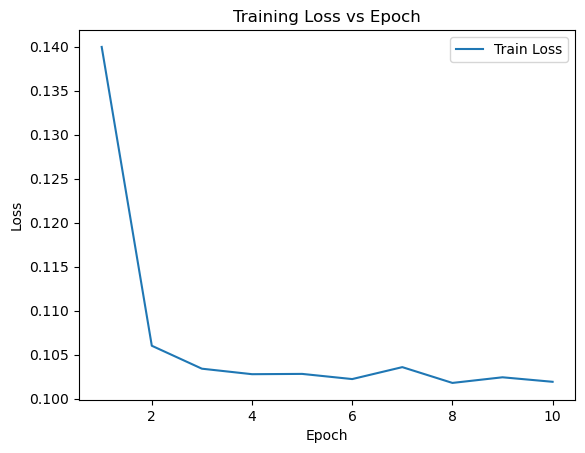

In [4]:
import matplotlib.pyplot as plt

def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]  # 返回 one-hot 编码
num_classes=10
train_x, train_y = train_set
test_x, test_y = test_set
train_x = train_x / 255.0
test_x = test_x / 255.0
train_x = train_x.reshape(-1, 3, 32, 32)
test_x = test_x.reshape(-1, 3, 32, 32)

train_x = torch.tensor(train_x).float()
test_x = torch.tensor(test_x).float()

# 定义 one-hot 编码函数
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]  # 返回 one-hot 编码

# 对标签进行 one-hot 编码
train_y = torch.tensor(train_y).long()
train_y_one_hot = one_hot_encode(train_y, num_classes).float()  # 对 train_y 进行 one-hot 编码

test_y = torch.tensor(test_y).long()
test_y_one_hot = one_hot_encode(test_y, num_classes).float()  # 对 test_y 进行 one-hot 编码

# 创建 TensorDataset 对象
train_dataset = TensorDataset(train_x, train_y_one_hot)
test_dataset = TensorDataset(test_x, test_y_one_hot)

# 创建 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 打印 train_loader 的形状，验证标签是 one-hot 编码
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)  # 应该输出 [batch_size, 3, 32, 32] 和 [batch_size, num_classes]
    break
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

criterion = nn.MSELoss()

# 记录每个epoch的损失
train_losses = []

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # MSE要求标签是float类型

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)  # 获取预测的类别索引
            _, true_labels = torch.max(labels, 1)  # 获取标签的类别索引（one-hot 转回类别索引）
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # 记录损失
        train_losses.append(epoch_loss)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # 获取预测的类别索引
            _, true_labels = torch.max(labels, 1)  # 获取标签的类别索引（one-hot 转回类别索引）
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy
# 假设 train_loader 和 test_loader 已经定义好了

model = FeatureExtractorAndClassifier(num_classes=10).cuda() 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 训练模型
train(model, train_loader, criterion, optimizer, num_epochs=10)

# 测试模型
test(model, test_loader)

# 绘制训练损失随epoch变化的图像
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

和我想的不太一样，因为在这个作业前面的尝试里，MSE是要优于交叉熵的

下面会用L2正则化

Epoch [1/10], Loss: 1.9657, Accuracy: 31.87%


Epoch [2/10], Loss: 1.8544, Accuracy: 36.19%


Epoch [3/10], Loss: 1.8443, Accuracy: 37.21%


Epoch [4/10], Loss: 1.8019, Accuracy: 38.55%


Epoch [5/10], Loss: 1.8031, Accuracy: 38.26%


Epoch [6/10], Loss: 1.8003, Accuracy: 38.45%


Epoch [7/10], Loss: 1.8078, Accuracy: 38.75%


Epoch [8/10], Loss: 1.7716, Accuracy: 39.42%


Epoch [9/10], Loss: 1.7716, Accuracy: 39.76%


Epoch [10/10], Loss: 1.7605, Accuracy: 39.98%


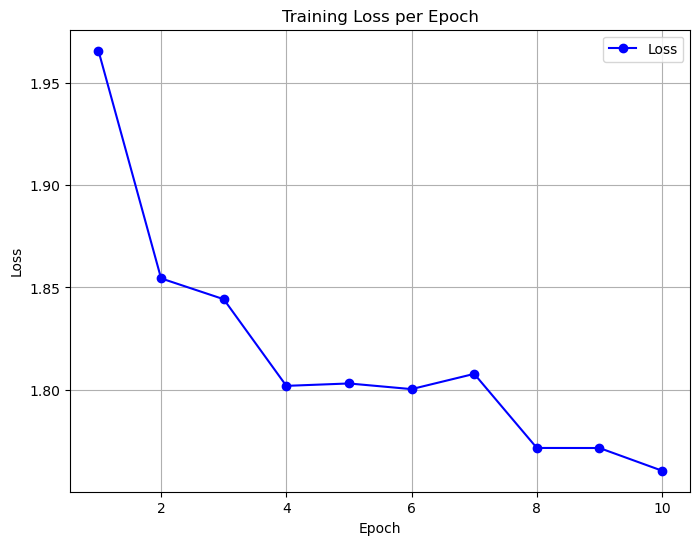

Test Accuracy: 34.68%


34.68

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def train(model, train_loader, criterion, optimizer, num_epochs=10): 
    model.train()  
    epoch_losses = []  # 用于存储每个epoch的loss
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 使用 tqdm 进度条显示训练过程
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        epoch_losses.append(epoch_loss)  # 记录每个epoch的损失
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    return epoch_losses  # 返回损失值，用于绘制图表

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 创建模型，定义损失函数和优化器
model = FeatureExtractorAndClassifier(num_classes=10).cuda() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 训练模型并记录每个epoch的损失
epoch_losses = train(model, train_loader, criterion, optimizer, num_epochs=10)

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', color='b', label='Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 测试模型
test(model, test_loader)

在加用dropout试试，顺便把全连接网络变成双层全连接网络，网络结构为：
2048-512-256-10，层与层之间有RELU

In [18]:
class FeatureExtractorAndClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.1):
        super(FeatureExtractorAndClassifier, self).__init__()
        
        # 加载已经保存的编码器（特征提取部分）
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # 加载已经保存的编码器权重
        self.encoder.load_state_dict(torch.load('encoder.pth'))
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # 添加双层全连接网络
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 第一层全连接
        self.fc2 = nn.Linear(512, 256)          # 第二层全连接
        self.fc3 = nn.Linear(256, num_classes)  # 输出层
        
        # Dropout 层
        self.dropout = nn.Dropout(dropout_rate)  # Dropout 层，防止过拟合
        
        self.relu = nn.ReLU()  # 激活函数
        
    def forward(self, x):
        # 提取特征
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # 展平（flatten）以便进入全连接层
        x = self.fc1(x)            # 第一层全连接
        x = self.relu(x)           # ReLU 激活
        x = self.dropout(x)        # Dropout
        x = self.fc2(x)            # 第二层全连接
        x = self.relu(x)           # ReLU 激活
        x = self.dropout(x)        # Dropout
        x = self.fc3(x)            # 输出层
        return x

Epoch [1/10], Loss: 1.9026, Accuracy: 30.55%
Epoch [2/10], Loss: 1.7548, Accuracy: 36.84%
Epoch [3/10], Loss: 1.6882, Accuracy: 39.34%
Epoch [4/10], Loss: 1.6536, Accuracy: 40.41%
Epoch [5/10], Loss: 1.6215, Accuracy: 41.50%
Epoch [6/10], Loss: 1.6095, Accuracy: 41.86%
Epoch [7/10], Loss: 1.5902, Accuracy: 42.83%
Epoch [8/10], Loss: 1.5727, Accuracy: 43.04%
Epoch [9/10], Loss: 1.5640, Accuracy: 43.70%
Epoch [10/10], Loss: 1.5507, Accuracy: 44.00%
Test Accuracy: 45.28%


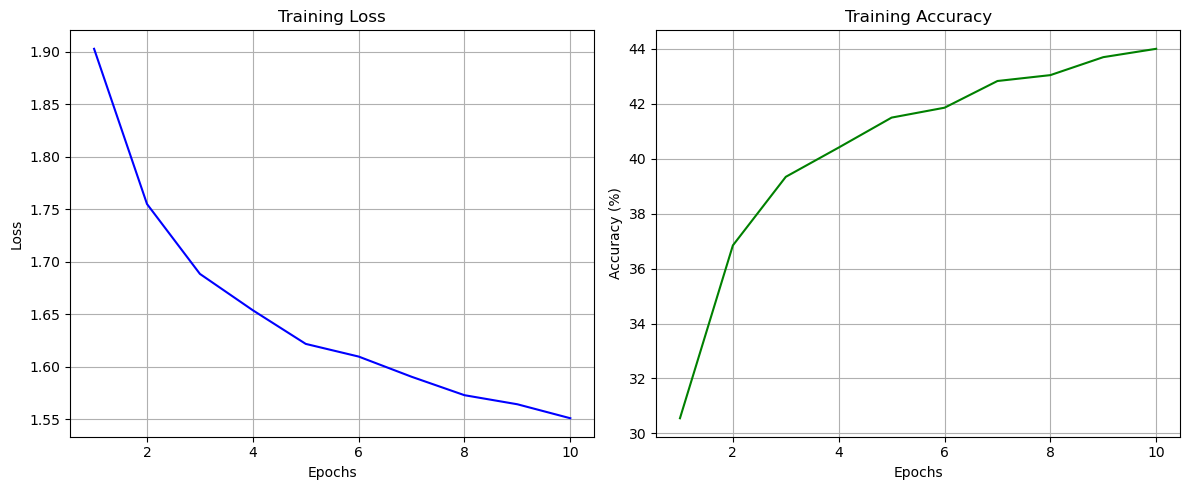

In [19]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# 定义模型，损失函数和优化器
model = FeatureExtractorAndClassifier(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型的代码
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    epoch_losses = []  # 用于存储每个epoch的loss
    epoch_accuracies = []  # 用于存储每个epoch的准确率
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        epoch_losses.append(epoch_loss)  # 记录每个epoch的损失
        epoch_accuracies.append(epoch_acc)  # 记录每个epoch的准确率
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    return epoch_losses, epoch_accuracies  # 返回损失和准确率，用于绘制图表

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 模型训练和测试
epoch_losses, epoch_accuracies = train(model, train_loader, criterion, optimizer, num_epochs=10)
test(model, test_loader)

# 绘制Loss和Accuracy图
def plot_training_history(epoch_losses, epoch_accuracies):
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 绘制 Loss 图
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # 绘制 Accuracy 图
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 绘制图表
plot_training_history(epoch_losses, epoch_accuracies)

上面的数据是在dropout为0.1的时候尝试出来的，为啥设置的这么低呢，因为dropout为0.5直接雪崩了，甚至还不如一层的
不过dropout就是为了防过拟合的，所以按理来说我应该多训练几轮

Epoch [1/50], Loss: 1.8985, Accuracy: 30.93%
Epoch [2/50], Loss: 1.7538, Accuracy: 36.71%
Epoch [3/50], Loss: 1.6962, Accuracy: 38.61%
Epoch [4/50], Loss: 1.6569, Accuracy: 40.34%
Epoch [5/50], Loss: 1.6355, Accuracy: 41.08%
Epoch [6/50], Loss: 1.6086, Accuracy: 41.82%
Epoch [7/50], Loss: 1.5919, Accuracy: 42.47%
Epoch [8/50], Loss: 1.5807, Accuracy: 43.08%
Epoch [9/50], Loss: 1.5711, Accuracy: 43.29%
Epoch [10/50], Loss: 1.5625, Accuracy: 43.87%
Epoch [11/50], Loss: 1.5525, Accuracy: 44.12%
Epoch [12/50], Loss: 1.5402, Accuracy: 44.61%
Epoch [13/50], Loss: 1.5371, Accuracy: 44.74%
Epoch [14/50], Loss: 1.5271, Accuracy: 45.06%
Epoch [15/50], Loss: 1.5227, Accuracy: 45.24%
Epoch [16/50], Loss: 1.5147, Accuracy: 45.60%
Epoch [17/50], Loss: 1.5145, Accuracy: 45.34%
Epoch [18/50], Loss: 1.5082, Accuracy: 45.87%
Epoch [19/50], Loss: 1.4983, Accuracy: 46.06%
Epoch [20/50], Loss: 1.4978, Accuracy: 46.09%
Epoch [21/50], Loss: 1.4904, Accuracy: 46.45%
Epoch [22/50], Loss: 1.4868, Accuracy: 46.4

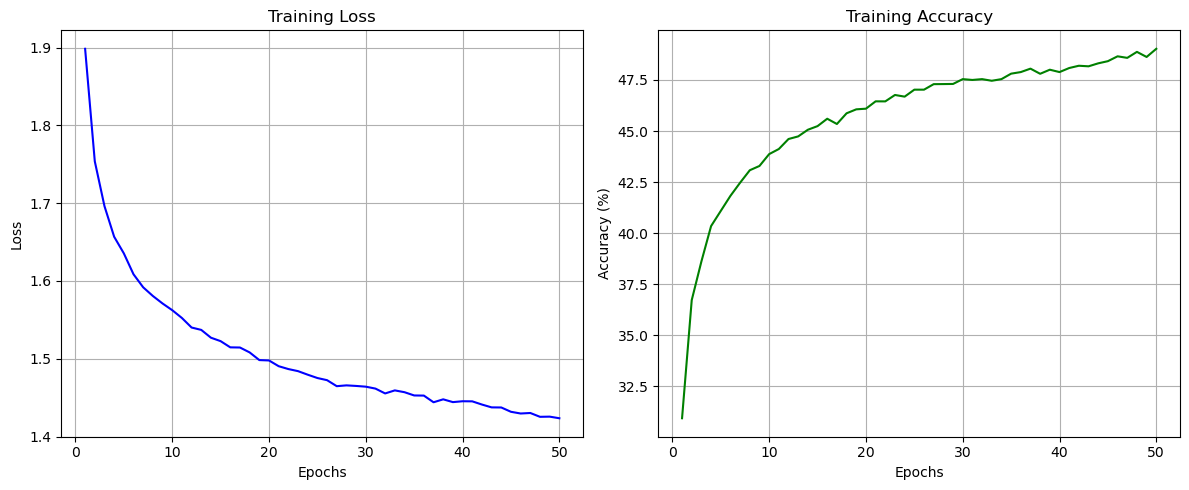

In [20]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# 定义模型，损失函数和优化器
model = FeatureExtractorAndClassifier(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型的代码
def train(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    epoch_losses = []  # 用于存储每个epoch的loss
    epoch_accuracies = []  # 用于存储每个epoch的准确率
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        epoch_losses.append(epoch_loss)  # 记录每个epoch的损失
        epoch_accuracies.append(epoch_acc)  # 记录每个epoch的准确率
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    return epoch_losses, epoch_accuracies  # 返回损失和准确率，用于绘制图表

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 模型训练和测试
epoch_losses, epoch_accuracies = train(model, train_loader, criterion, optimizer, num_epochs=50)
test(model, test_loader)

# 绘制Loss和Accuracy图
def plot_training_history(epoch_losses, epoch_accuracies):
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 绘制 Loss 图
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # 绘制 Accuracy 图
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 绘制图表
plot_training_history(epoch_losses, epoch_accuracies)

下面是没有dropout（dropout为0）的对照组

Epoch [1/50], Loss: 1.8477, Accuracy: 32.91%
Epoch [2/50], Loss: 1.6614, Accuracy: 40.35%
Epoch [3/50], Loss: 1.5871, Accuracy: 42.86%
Epoch [4/50], Loss: 1.5431, Accuracy: 44.81%
Epoch [5/50], Loss: 1.4991, Accuracy: 46.41%
Epoch [6/50], Loss: 1.4767, Accuracy: 47.03%
Epoch [7/50], Loss: 1.4456, Accuracy: 48.14%
Epoch [8/50], Loss: 1.4278, Accuracy: 48.86%
Epoch [9/50], Loss: 1.4051, Accuracy: 49.76%
Epoch [10/50], Loss: 1.3841, Accuracy: 50.49%
Epoch [11/50], Loss: 1.3687, Accuracy: 51.17%
Epoch [12/50], Loss: 1.3519, Accuracy: 51.89%
Epoch [13/50], Loss: 1.3368, Accuracy: 52.15%
Epoch [14/50], Loss: 1.3242, Accuracy: 52.64%
Epoch [15/50], Loss: 1.3193, Accuracy: 52.57%
Epoch [16/50], Loss: 1.3125, Accuracy: 52.96%
Epoch [17/50], Loss: 1.2940, Accuracy: 53.40%
Epoch [18/50], Loss: 1.2805, Accuracy: 54.19%
Epoch [19/50], Loss: 1.2734, Accuracy: 54.30%
Epoch [20/50], Loss: 1.2675, Accuracy: 54.48%
Epoch [21/50], Loss: 1.2573, Accuracy: 54.80%
Epoch [22/50], Loss: 1.2552, Accuracy: 54.7

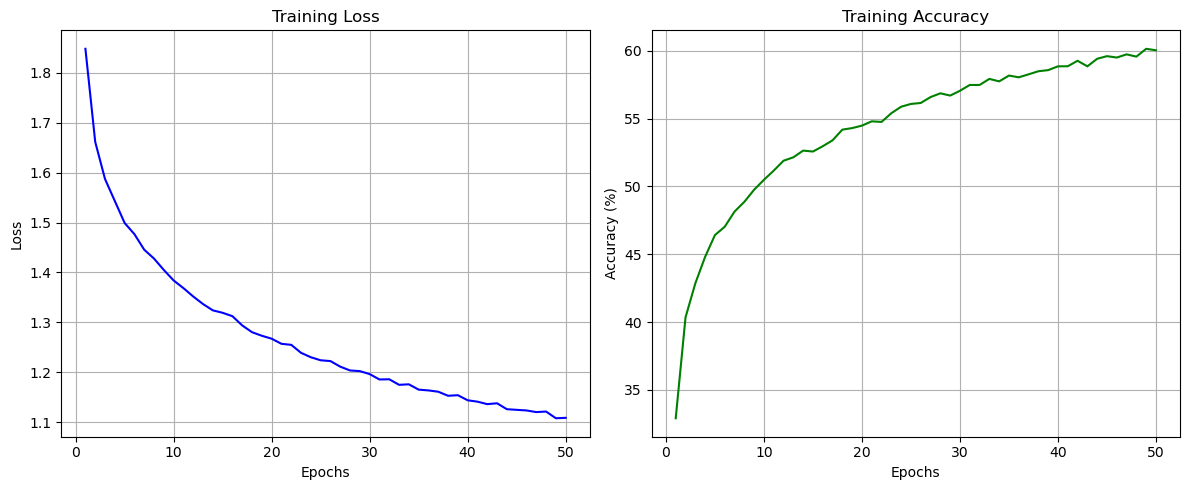

In [21]:
class FeatureExtractorAndClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0):
        super(FeatureExtractorAndClassifier, self).__init__()
        
        # 加载已经保存的编码器（特征提取部分）
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # 加载已经保存的编码器权重
        self.encoder.load_state_dict(torch.load('encoder.pth'))
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # 添加双层全连接网络
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 第一层全连接
        self.fc2 = nn.Linear(512, 256)          # 第二层全连接
        self.fc3 = nn.Linear(256, num_classes)  # 输出层
        
        # Dropout 层
        self.dropout = nn.Dropout(dropout_rate)  # Dropout 层，防止过拟合
        
        self.relu = nn.ReLU()  # 激活函数
        
    def forward(self, x):
        # 提取特征
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # 展平（flatten）以便进入全连接层
        x = self.fc1(x)            # 第一层全连接
        x = self.relu(x)           # ReLU 激活
        x = self.dropout(x)        # Dropout
        x = self.fc2(x)            # 第二层全连接
        x = self.relu(x)           # ReLU 激活
        x = self.dropout(x)        # Dropout
        x = self.fc3(x)            # 输出层
        return x
    
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# 定义模型，损失函数和优化器
model = FeatureExtractorAndClassifier(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型的代码
def train(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    epoch_losses = []  # 用于存储每个epoch的loss
    epoch_accuracies = []  # 用于存储每个epoch的准确率
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        epoch_losses.append(epoch_loss)  # 记录每个epoch的损失
        epoch_accuracies.append(epoch_acc)  # 记录每个epoch的准确率
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    return epoch_losses, epoch_accuracies  # 返回损失和准确率，用于绘制图表

def test(model, test_loader):
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 模型训练和测试
epoch_losses, epoch_accuracies = train(model, train_loader, criterion, optimizer, num_epochs=50)
test(model, test_loader)

# 绘制Loss和Accuracy图
def plot_training_history(epoch_losses, epoch_accuracies):
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 绘制 Loss 图
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # 绘制 Accuracy 图
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 绘制图表
plot_training_history(epoch_losses, epoch_accuracies)

没有dropout的效果明显比dropout更好，我有个猜想：
因为前面本来就有自动编码器，特征相较于原先要更加重要，丢弃了的话损失比较大